<a href="https://colab.research.google.com/github/harirm85/Hari_ML_workshop/blob/main/Home_Credit_App_CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cross Vlidation of XG Boost

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.float_format = '{:,.2f}'.format

In [12]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Copy the Jason file and set security
!mkdir -p ~/.kaggle
!cp '/content/drive/MyDrive/Kaggle/kaggle.json' ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

#Download data
!kaggle competitions download -c home-credit-default-risk

import zipfile

# Specify the path to the downloaded zip file
zip_path = "/content/home-credit-default-risk.zip"

# Specify the directory to extract the files to
extract_path = "/content/home-credit-default-risk"

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

Mounted at /content/drive
home-credit-default-risk.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
#Take app train data and load to DF
app_data = pd.read_csv('/content/home-credit-default-risk/application_train.csv')

print(app_data.shape)

(307511, 122)


In [4]:
#Set Features and label fields
label_col = 'TARGET'
feature_columns = app_data.columns
feature_columns = feature_columns.drop (['SK_ID_CURR', 'TARGET']) 

#Check duplicates
duplicates = app_data.duplicated(feature_columns).sum(axis=0)
print(duplicates) #no dups for all fields

#Fix data types
dtypes= {'NAME_CONTRACT_TYPE': 'category' ,'CODE_GENDER': 'category','FLAG_OWN_CAR': 'category','FLAG_OWN_REALTY': 'category'
  , 'CNT_CHILDREN': 'category' 
  ,'NAME_TYPE_SUITE': 'category','NAME_INCOME_TYPE': 'category','NAME_EDUCATION_TYPE': 'category','NAME_FAMILY_STATUS': 'category'
  ,'NAME_HOUSING_TYPE': 'category','FLAG_MOBIL': 'category','FLAG_EMP_PHONE': 'category','FLAG_WORK_PHONE': 'category'
  ,'FLAG_CONT_MOBILE': 'category','FLAG_PHONE': 'category','FLAG_EMAIL': 'category','OCCUPATION_TYPE': 'category'
  ,'CNT_FAM_MEMBERS': 'category','REGION_RATING_CLIENT': 'category','REGION_RATING_CLIENT_W_CITY': 'category'  
  ,'WEEKDAY_APPR_PROCESS_START': 'category','HOUR_APPR_PROCESS_START': 'category','REG_REGION_NOT_LIVE_REGION': 'category'
  ,'REG_REGION_NOT_WORK_REGION': 'category','LIVE_REGION_NOT_WORK_REGION': 'category','REG_CITY_NOT_LIVE_CITY': 'category'
  ,'REG_CITY_NOT_WORK_CITY': 'category','LIVE_CITY_NOT_WORK_CITY': 'category','ORGANIZATION_TYPE': 'category'
  ,'FONDKAPREMONT_MODE': 'category','HOUSETYPE_MODE': 'category','WALLSMATERIAL_MODE': 'category', 'EMERGENCYSTATE_MODE': 'category'
  ,'FLAG_DOCUMENT_2': 'category','FLAG_DOCUMENT_3': 'category','FLAG_DOCUMENT_4': 'category', 'FLAG_DOCUMENT_5': 'category'
  ,'FLAG_DOCUMENT_6': 'category','FLAG_DOCUMENT_7': 'category','FLAG_DOCUMENT_8': 'category', 'FLAG_DOCUMENT_9': 'category'
  ,'FLAG_DOCUMENT_10': 'category','FLAG_DOCUMENT_11': 'category','FLAG_DOCUMENT_12': 'category', 'FLAG_DOCUMENT_13': 'category'
  ,'FLAG_DOCUMENT_14': 'category','FLAG_DOCUMENT_15': 'category','FLAG_DOCUMENT_16': 'category', 'FLAG_DOCUMENT_17': 'category'
  ,'FLAG_DOCUMENT_18': 'category','FLAG_DOCUMENT_19': 'category','FLAG_DOCUMENT_20': 'category', 'FLAG_DOCUMENT_21': 'category'
 }

app_data = app_data.astype(dtypes)

0


Analyze these Categories

AttributeError: ignored

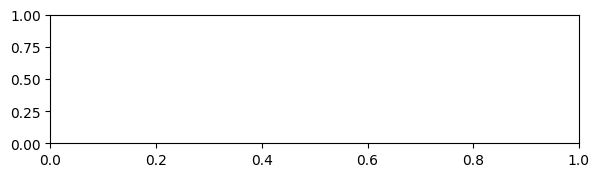

In [ ]:
plt.figure(figsize=(15, 120))

for i, c in enumerate(app_data.select_dtypes(include='category').columns):
    plt.subplot(60,2,i+1)
    sns.barplot(x=app_data[c],y=app_data[c].count(),hue=app_data['TARGET'])
    plt.title('Hist plot for field:' + c)
    plt.xlabel('')
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

FI - Add ratios

In [5]:
# Add ratios
app_data['CREDIT_TO_INCOME'] = app_data['AMT_CREDIT']/app_data['AMT_INCOME_TOTAL']
app_data['CREDIT_TO_PRICE'] = app_data['AMT_CREDIT']/app_data['AMT_GOODS_PRICE']
app_data['ANNUITY_TO_INCOME'] = app_data['AMT_ANNUITY']/app_data['AMT_INCOME_TOTAL']


In [ ]:
app_data.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 125 columns):
 #    Column                        Non-Null Count   Dtype   
---   ------                        --------------   -----   
 0    SK_ID_CURR                    307511 non-null  int64   
 1    TARGET                        307511 non-null  int64   
 2    NAME_CONTRACT_TYPE            307511 non-null  category
 3    CODE_GENDER                   307511 non-null  category
 4    FLAG_OWN_CAR                  307511 non-null  category
 5    FLAG_OWN_REALTY               307511 non-null  category
 6    CNT_CHILDREN                  307511 non-null  category
 7    AMT_INCOME_TOTAL              307511 non-null  float64 
 8    AMT_CREDIT                    307511 non-null  float64 
 9    AMT_ANNUITY                   307499 non-null  float64 
 10   AMT_GOODS_PRICE               307233 non-null  float64 
 11   NAME_TYPE_SUITE               306219 non-null  category
 12   NAME_INCOME_TY

In [ ]:
app_data.describe()

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,...,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,"307,511.00","307,511.00","307,499.00","307,233.00","307,511.00","307,511.00","307,511.00","307,511.00","307,511.00","104,582.00",...,"306,490.00","306,490.00","306,490.00","307,510.00","265,992.00","265,992.00","265,992.00","265,992.00","265,992.00","265,992.00"
mean,"168,797.92","599,026.00","27,108.57","538,396.21",0.02,"-16,037.00","63,815.05","-4,986.12","-2,994.20",12.06,...,0.14,1.41,0.10,-962.86,0.01,0.01,0.03,0.27,0.27,1.90
std,"237,123.15","402,490.78","14,493.74","369,446.46",0.01,"4,363.99","141,275.77","3,522.89","1,509.45",11.94,...,0.45,2.38,0.36,826.81,0.08,0.11,0.20,0.92,0.79,1.87
min,"25,650.00","45,000.00","1,615.50","40,500.00",0.00,"-25,229.00","-17,912.00","-24,672.00","-7,197.00",0.00,...,0.00,0.00,0.00,"-4,292.00",0.00,0.00,0.00,0.00,0.00,0.00
25%,"112,500.00","270,000.00","16,524.00","238,500.00",0.01,"-19,682.00","-2,760.00","-7,479.50","-4,299.00",5.00,...,0.00,0.00,0.00,"-1,570.00",0.00,0.00,0.00,0.00,0.00,0.00
50%,"147,150.00","513,531.00","24,903.00","450,000.00",0.02,"-15,750.00","-1,213.00","-4,504.00","-3,254.00",9.00,...,0.00,0.00,0.00,-757.00,0.00,0.00,0.00,0.00,0.00,1.00
75%,"202,500.00","808,650.00","34,596.00","679,500.00",0.03,"-12,413.00",-289.00,"-2,010.00","-1,720.00",15.00,...,0.00,2.00,0.00,-274.00,0.00,0.00,0.00,0.00,0.00,3.00
max,"117,000,000.00","4,050,000.00","258,025.50","4,050,000.00",0.07,"-7,489.00","365,243.00",0.00,0.00,91.00,...,34.00,344.00,24.00,0.00,4.00,9.00,8.00,27.00,261.00,25.00


In [6]:
#Find missing Values
missed_values = app_data.isna().sum(axis=0) / 307511
print(missed_values.sort_values(ascending=False).head(50)) 

#40+ Fields have more than half data as null
#We can remove them based on domain knowledge to correct the data
#We can add missing values, many ways, 1- replace mean

COMMONAREA_MODE                0.70
COMMONAREA_AVG                 0.70
COMMONAREA_MEDI                0.70
NONLIVINGAPARTMENTS_AVG        0.69
NONLIVINGAPARTMENTS_MODE       0.69
NONLIVINGAPARTMENTS_MEDI       0.69
FONDKAPREMONT_MODE             0.68
LIVINGAPARTMENTS_AVG           0.68
LIVINGAPARTMENTS_MODE          0.68
LIVINGAPARTMENTS_MEDI          0.68
FLOORSMIN_MODE                 0.68
FLOORSMIN_AVG                  0.68
FLOORSMIN_MEDI                 0.68
YEARS_BUILD_MODE               0.66
YEARS_BUILD_AVG                0.66
YEARS_BUILD_MEDI               0.66
OWN_CAR_AGE                    0.66
LANDAREA_MODE                  0.59
LANDAREA_AVG                   0.59
LANDAREA_MEDI                  0.59
BASEMENTAREA_MODE              0.59
BASEMENTAREA_AVG               0.59
BASEMENTAREA_MEDI              0.59
EXT_SOURCE_1                   0.56
NONLIVINGAREA_MEDI             0.55
NONLIVINGAREA_AVG              0.55
NONLIVINGAREA_MODE             0.55
ELEVATORS_MEDI              

In [7]:
#Fill null with NoValue
for col in app_data.columns:
    if pd.api.types.is_categorical_dtype(app_data[col]) and app_data[col].isna().sum() > 0:
        app_data[col] = app_data[col].cat.add_categories(['NoValue'])
        app_data[col] = app_data[col].fillna('NoValue')

# One Hot Encoding

In [8]:
app_data['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [9]:
#EDA
# correlation with Target - target value
corr_features = pd.DataFrame()
corr_features['FI'] = app_data.corr()[label_col]
corr_features['FI_MOD']  = corr_features['FI'].abs()
print(corr_features.sort_values(by='FI_MOD',ascending=False).head(50)) 
#corr_features.style.background_gradient(cmap='viridis')

#We can remove least 10 features whose correltion is less than 1 percent

<ipython-input-9-ad32af8aef5c>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_features['FI'] = app_data.corr()[label_col]


                              FI  FI_MOD
TARGET                      1.00    1.00
EXT_SOURCE_3               -0.18    0.18
EXT_SOURCE_2               -0.16    0.16
EXT_SOURCE_1               -0.16    0.16
DAYS_BIRTH                  0.08    0.08
CREDIT_TO_PRICE             0.07    0.07
DAYS_LAST_PHONE_CHANGE      0.06    0.06
DAYS_ID_PUBLISH             0.05    0.05
DAYS_EMPLOYED              -0.04    0.04
FLOORSMAX_AVG              -0.04    0.04
FLOORSMAX_MEDI             -0.04    0.04
FLOORSMAX_MODE             -0.04    0.04
DAYS_REGISTRATION           0.04    0.04
AMT_GOODS_PRICE            -0.04    0.04
OWN_CAR_AGE                 0.04    0.04
REGION_POPULATION_RELATIVE -0.04    0.04
ELEVATORS_AVG              -0.03    0.03
ELEVATORS_MEDI             -0.03    0.03
FLOORSMIN_AVG              -0.03    0.03
FLOORSMIN_MEDI             -0.03    0.03
LIVINGAREA_AVG             -0.03    0.03
LIVINGAREA_MEDI            -0.03    0.03
FLOORSMIN_MODE             -0.03    0.03
TOTALAREA_MODE  

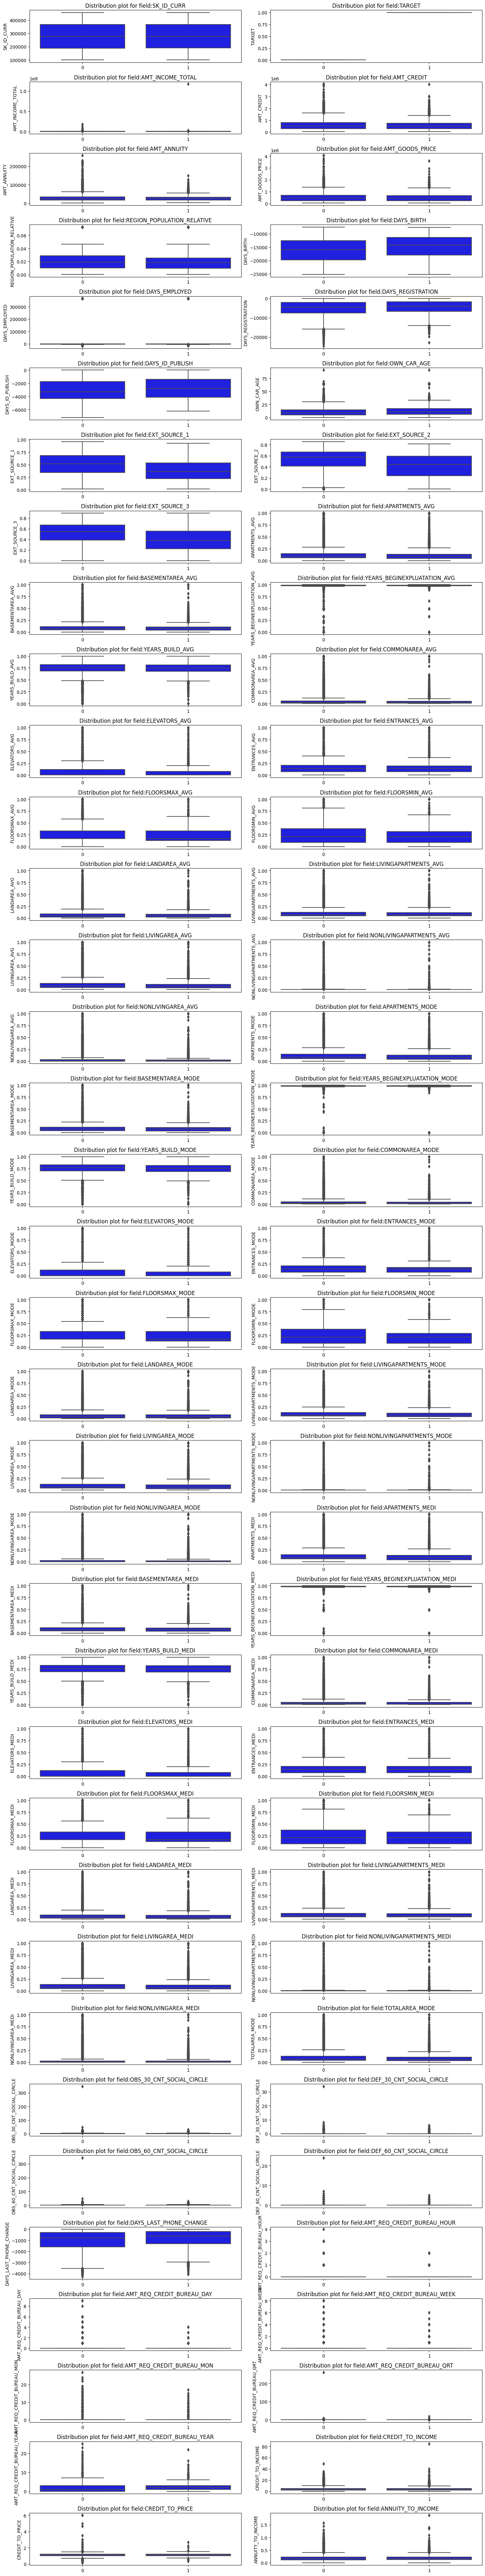

In [ ]:
# outlier check
plt.figure(figsize=(15, 80))

for i, c in enumerate(app_data.select_dtypes(exclude='category').columns):
    plt.subplot(36,2,i+1)
    sns.boxplot(y=app_data[c],x=app_data['TARGET'], color='blue')
    plt.title('Distribution plot for field:' + c)
    plt.xlabel('')
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    
    # plt.subplot(10,2,i*2+2)
    # sns.boxplot(app_data[c].apply('log1p'), color='red')
    # plt.title('Log1p distribution plot for field:' + c)
    # plt.xlabel('')
    # plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

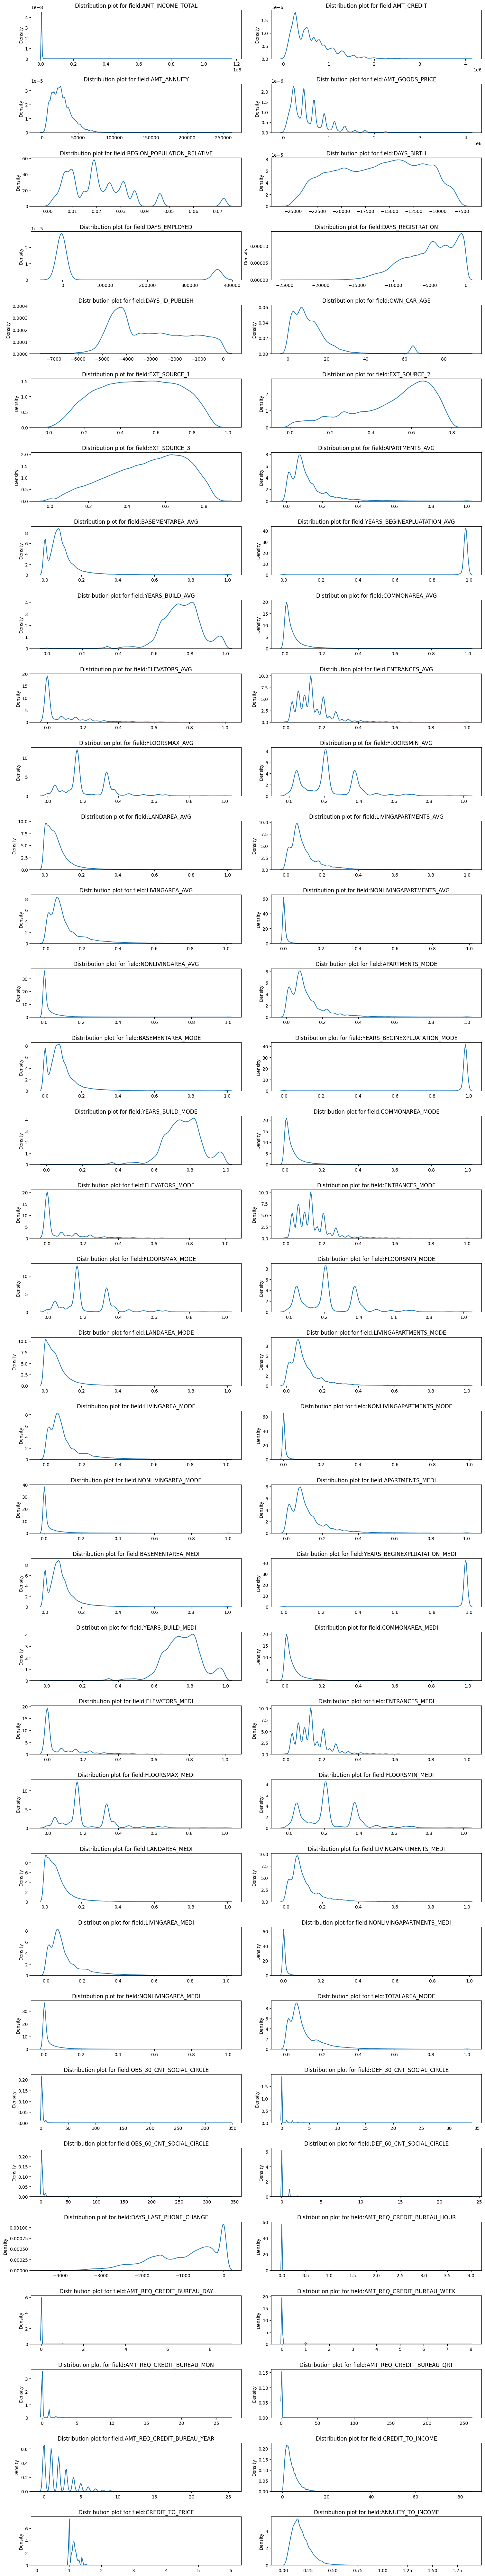

In [ ]:
plt.figure(figsize=(15, 80))

for i, c in enumerate(app_data.select_dtypes(exclude='category').columns):
    plt.subplot(35,2,i+1)
    sns.kdeplot(app_data[c])
    plt.title('Distribution plot for field:' + c)
    plt.xlabel('')
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

# Encoding Labels

In [ ]:
# from sklearn.preprocessing import LabelEncoder, RobustScaler
# le = LabelEncoder()
# app_data['gender'] = le.fit_transform(app_data['gender'])
# app_data.gender.head()

In [ ]:
# rs = RobustScaler()
# for c in df[['age', 'gender', 'total_bilirubin', 'alkaline_phosphotase', 'alamine_aminotransferase', 'albumin_and_globulin_ratio']].columns:
#     df[c] = rs.fit_transform(df[c].values.reshape(-1, 1))
# df.head()

In [ ]:
app_data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
SK_ID_CURR,"307,511.00","307,511.00","100,002.00",1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TARGET,"307,511.00",2.00,0.00,"282,686.00",NaN,NaN,NaN,NaN,NaN,NaN,NaN
NAME_CONTRACT_TYPE,307511,2,Cash loans,278232,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CODE_GENDER,307511,3,F,202448,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FLAG_OWN_CAR,307511,2,N,202924,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
AMT_REQ_CREDIT_BUREAU_DAY,"265,992.00",NaN,NaN,NaN,0.01,0.11,0.00,0.00,0.00,0.00,9.00
AMT_REQ_CREDIT_BUREAU_WEEK,"265,992.00",NaN,NaN,NaN,0.03,0.20,0.00,0.00,0.00,0.00,8.00
AMT_REQ_CREDIT_BUREAU_MON,"265,992.00",NaN,NaN,NaN,0.27,0.92,0.00,0.00,0.00,0.00,27.00
AMT_REQ_CREDIT_BUREAU_QRT,"265,992.00",NaN,NaN,NaN,0.27,0.79,0.00,0.00,0.00,0.00,261.00


# Pull other data

In [13]:
bur_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/bureau_summary.csv')
prev_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Prev_summary.csv')

print(app_data.shape)
print(bur_data.shape)
print(prev_data.shape)

(307511, 125)
(305811, 48)
(338857, 53)


In [14]:
combined_data=app_data.merge(bur_data,on='SK_ID_CURR',how='left',suffixes=('_1','_2'))
combined_data.shape

(307511, 172)

In [15]:
full_data = combined_data.merge(bur_data,on='SK_ID_CURR',how='left',suffixes=('_1','_2'))
full_data.shape

(307511, 219)

In [17]:
#Set Features and label fields
label_col = 'TARGET'
feature_columns = full_data.columns
feature_columns = feature_columns.drop (['SK_ID_CURR', 'TARGET']) 

Split Data and Model

In [16]:
full_data[label_col].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(full_data[feature_columns], full_data[label_col], test_size=0.2, random_state=123)

print('Train values shape:', X_train.shape)
print('Test values shape:', X_test.shape)
print('Train target shape:', y_train.shape)
print('Test target shape:', y_test.shape)

Train values shape: (246008, 217)
Test values shape: (61503, 217)
Train target shape: (246008,)
Test target shape: (61503,)


In [ ]:
from sklearn.utils import class_weight
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

model = XGBClassifier(random_state=123,tree_method="hist",enable_categorical='True')
model.fit(X_train, y_train)
y_train_hat = model.predict(X_train)
y_test_hat = model.predict(X_test)

print(model)
print('Train performance')
print('-------------------------------------------------------')
print(classification_report(y_train, y_train_hat))

print('Test performance')
print('-------------------------------------------------------')
print(classification_report(y_test, y_test_hat))

print('Roc_auc score')
print('-------------------------------------------------------')
print(roc_auc_score(y_test, y_test_hat))
print('')

print('Confusion matrix')
print('-------------------------------------------------------')
print(confusion_matrix(y_test, y_test_hat))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical='True', eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=123, ...)
Train performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      1.00      0.96    226198
           1       0.85      0.10      0.17     19810

    accura

In [ ]:
from sklearn.utils import class_weight
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

model = XGBClassifier(random_state=123,tree_method="hist",enable_categorical='True',scale_pos_weight=11,learning_rate= 0.05, n_estimators= 500)
model.fit(X_train, y_train)
y_train_hat = model.predict(X_train)
y_test_hat = model.predict(X_test)

print(model)
print('Train performance')
print('-------------------------------------------------------')
print(classification_report(y_train, y_train_hat))

print('Test performance')
print('-------------------------------------------------------')
print(classification_report(y_test, y_test_hat))

print('Roc_auc score')
print('-------------------------------------------------------')
print(roc_auc_score(y_test, y_test_hat))
print('')

print('Confusion matrix')
print('-------------------------------------------------------')
print(confusion_matrix(y_test, y_test_hat))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical='True', eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=123, ...)
Train performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.79      0.87    226198
           1       0.25      0.81      0.38     19810

    accura

Parameter Tuning

In [ ]:
# XGBoost
# n_jobs=-1 to allow run it on all cores
from sklearn.utils import class_weight
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import GridSearchCV, KFold

params = {
    # 'n_estimators': [200, 500,1000],
    # 'learning_rate': [0.01,0.05,0.1],
    # 'booster': ['gbtree', 'gblinear'],
    # 'scale_pos_weight' = 11,
    'gamma': [0, 0.5, 1],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [0.5, 1, 5]
    #'base_score': [0.2, 0.5, 1]
}

gs2 = GridSearchCV(XGBClassifier(scale_pos_weight = 11,random_state=123,tree_method="hist",enable_categorical='True',learning_rate= 0.05, n_estimators= 500), params,
                   scoring='f1' ,n_jobs=-1, cv=KFold(n_splits=3),error_score='raise')
gs2.fit(X_train, y_train)

print('Best score:', gs2.best_score_)
print('Best score:', gs2.best_params_)


# Best score: 0.8142702681892358
# Best score: {'learning_rate': 0.1, 'n_estimators': 500, 'scale_pos_weight': 10}

KeyboardInterrupt: ignored